In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import load_model
from image_augmentation import RandomColorAffine

from sklearn.metrics import confusion_matrix, classification_report

2022-08-03 22:57:18.273854: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### Confusion Matrix

In [2]:
# Load best model
model = load_model("../Models/10%_simclr_semi_supervised_model_bs64.33-0.27.h5",custom_objects={'RandomColorAffine': RandomColorAffine})

2022-08-03 22:57:23.255263: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-03 22:57:23.255298: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-3-32): /proc/driver/nvidia/version does not exist
2022-08-03 22:57:23.255679: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#generate test batch
test_path = "../Data/OCT2017 /test/"
image_size = 224
seed = 42

test_batch = tf.keras.utils.image_dataset_from_directory(test_path,
                                                         image_size=(image_size, image_size),
                                                         shuffle=False,
                                                         batch_size = 64,
                                                         seed=seed,)

Found 968 files belonging to 4 classes.


16/16 [==============================] - 7s 459ms/step
There were 940 correct predictions in 968 tests for an accuracy of  97.11 % 


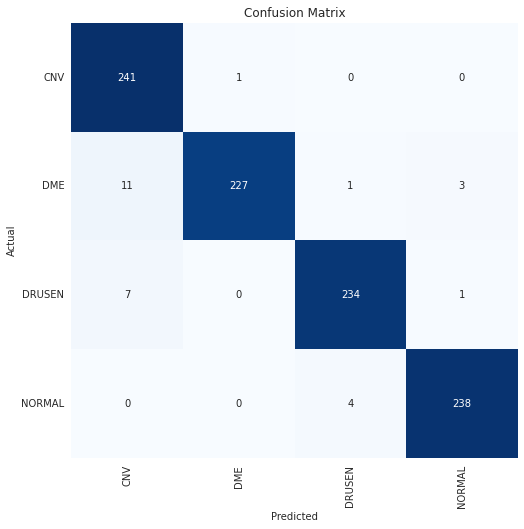

Classification Report:
----------------------
               precision    recall  f1-score   support

         CNV       0.93      1.00      0.96       242
         DME       1.00      0.94      0.97       242
      DRUSEN       0.98      0.97      0.97       242
     NORMARL       0.98      0.98      0.98       242

    accuracy                           0.97       968
   macro avg       0.97      0.97      0.97       968
weighted avg       0.97      0.97      0.97       968



In [5]:
#Print Confusion Matrix and Classification Report
class_names = ['CNV','DME','DRUSEN','NORMARL']

sns.set_style('darkgrid')
classes=test_batch.class_names # ordered list of class names

ytrue=[]

for images, label in test_batch:   
    for l in label:
        ytrue.append(classes[l]) # list of class names associated with each image file in test dataset 
        
ypred=[]
errors=0
count=0
preds=model.predict(test_batch, verbose=1) # predict the model on the test batch

for i, p in enumerate(preds):
    count +=1
    index=np.argmax(p) # get index of prediction with highest probability
    klass=classes[index] 
    ypred.append(klass)  
    if klass != ytrue[i]:
        errors +=1
acc= (count-errors)* 100/count
msg=f'There were {count-errors} correct predictions in {count} tests for an accuracy of {acc:6.2f} % '
print(msg) 

y_pred=np.array(ypred)
y_true=np.array(ytrue)

if len(classes)<= 30: # Can create up to 30 classes
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
clr = classification_report(ytrue, ypred, target_names=class_names)
print("Classification Report:\n----------------------\n", clr) 